<a href="https://colab.research.google.com/github/sefamertgungor/tumorDetection/blob/main/t1ce_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Proje/BraTS2020_TrainingData.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras

In [ ]:
pip install simpleitk

     |████████████████████████████████| 47.4MB 63kB/s 


In [ ]:
yol = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [ ]:
import os
os.listdir(yol)

['BraTS20_Training_004',
 'BraTS20_Training_024',
 'BraTS20_Training_005',
 'BraTS20_Training_016',
 'BraTS20_Training_023',
 'BraTS20_Training_021',
 'BraTS20_Training_037',
 'BraTS20_Training_009',
 'BraTS20_Training_006',
 'survival_info.csv',
 'BraTS20_Training_025',
 'BraTS20_Training_015',
 'BraTS20_Training_007',
 'BraTS20_Training_018',
 'BraTS20_Training_036',
 'name_mapping.csv',
 'BraTS20_Training_038',
 'BraTS20_Training_017',
 'BraTS20_Training_020',
 'BraTS20_Training_034',
 'BraTS20_Training_001',
 'BraTS20_Training_026',
 'BraTS20_Training_022',
 'BraTS20_Training_013',
 'BraTS20_Training_032',
 'BraTS20_Training_011',
 'BraTS20_Training_027',
 'BraTS20_Training_014',
 'BraTS20_Training_003',
 'BraTS20_Training_019',
 'BraTS20_Training_028',
 'BraTS20_Training_002',
 'BraTS20_Training_039',
 'BraTS20_Training_029',
 'BraTS20_Training_035',
 'BraTS20_Training_040',
 'BraTS20_Training_033',
 'BraTS20_Training_031',
 'BraTS20_Training_008',
 'BraTS20_Training_030',
 'BraTS

In [ ]:
len(os.listdir(yol))

42

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [ ]:
seg_geniş   = seg_array(yol,'**/*seg.nii',4)
seg_ödemsiz = seg_array(yol,'**/*seg.nii',3)
t1ce = train_array(yol,'**/*t1ce.nii')

In [ ]:
seg_geniş.shape, seg_ödemsiz.shape, t1ce.shape

((2800, 1, 240, 240), (2800, 1, 240, 240), (2800, 1, 240, 240))

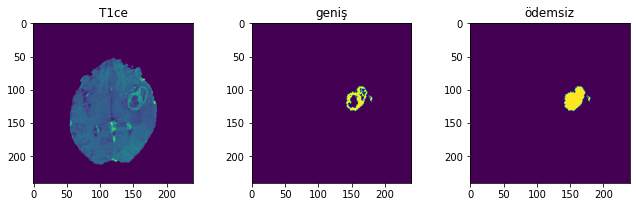

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[425,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_geniş[425,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_ödemsiz[425,0,:,:])

In [ ]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

def tumortoarray(tumor,segmentasyon):
    
    liste_boş= []

    for i in range(len(segmentasyon)):
        img = tümör_kırpma(tumor[i],segmentasyon[i])
        if len(img.shape) > 2:
            liste_boş.append(img)
            #print(f'{i}')

    return np.array(liste_boş)

ödemsiz = tumortoarray(seg_ödemsiz,seg_ödemsiz)
geniş = tumortoarray(seg_geniş,seg_ödemsiz)
t1ce_kırp = tumortoarray(t1ce,seg_ödemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


0
1
2
3
4
5
6
7
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532

In [ ]:
t1ce_kırp.shape, ödemsiz.shape, geniş.shape

((1249, 1, 64, 64), (1249, 1, 64, 64), (1249, 1, 64, 64))

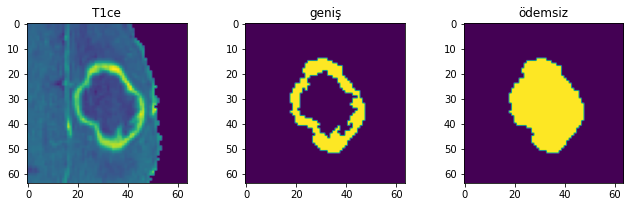

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[405,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş[405,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz[405,0,:,:])

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model_ödemsiz = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_ödemsiz.fit(t1ce_kırp, ödemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
100/100 [==============================] - 57s 65ms/step - loss: 0.4987 - dice_coef: 0.5013 - val_loss: 0.8954 - val_dice_coef: 0.1046
Epoch 2/5
100/100 [==============================] - 4s 38ms/step - loss: 0.2193 - dice_coef: 0.7807 - val_loss: 0.8125 - val_dice_coef: 0.1875
Epoch 3/5
100/100 [==============================] - 4s 39ms/step - loss: 0.1615 - dice_coef: 0.8385 - val_loss: 0.6294 - val_dice_coef: 0.3706
Epoch 4/5
100/100 [==============================] - 4s 39ms/step - loss: 0.1372 - dice_coef: 0.8628 - val_loss: 0.4097 - val_dice_coef: 0.5903
Epoch 5/5
100/100 [==============================] - 4s 39ms/step - loss: 0.1057 - dice_coef: 0.8943 - val_loss: 0.3006 - val_dice_coef: 0.6994


In [ ]:
model_geniş = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_geniş.fit(t1ce_kırp, geniş,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
100/100 [==============================] - 8s 51ms/step - loss: 0.6354 - dice_coef: 0.3645 - val_loss: 0.8436 - val_dice_coef: 0.1564
Epoch 2/5
100/100 [==============================] - 4s 40ms/step - loss: 0.4082 - dice_coef: 0.5918 - val_loss: 0.9363 - val_dice_coef: 0.0637
Epoch 3/5
100/100 [==============================] - 4s 40ms/step - loss: 0.3138 - dice_coef: 0.6862 - val_loss: 0.6470 - val_dice_coef: 0.3530
Epoch 4/5
100/100 [==============================] - 4s 41ms/step - loss: 0.2647 - dice_coef: 0.7353 - val_loss: 0.4343 - val_dice_coef: 0.5657
Epoch 5/5
100/100 [==============================] - 4s 44ms/step - loss: 0.2243 - dice_coef: 0.7757 - val_loss: 0.3188 - val_dice_coef: 0.6812


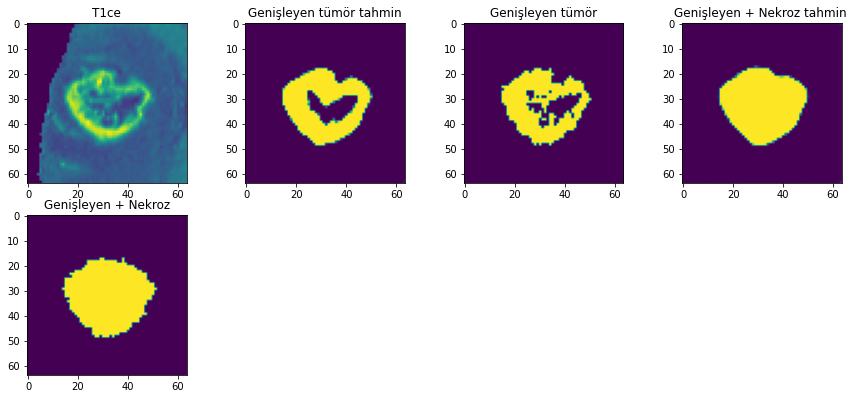

In [ ]:
x = 46

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model_geniş.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])